# Report 3 - FashonMNIST and Clothing Classification
* Name: Haohan Lin
* Student ID: 2015300010

<br><br>
## 1. Task Description
<br><br>
* ### Task Requirement
Build and train a CNN classification model with FashionMNIST dataset. Build a web crawler and collect clothing (i.e., T-shirt, shoes...) images from taobao. Then use the trained model to classify the collect images.
  * Multi-class classification
  * Web crawler
<br><br>
* ###  Data
The dataset consists of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.<br><br>

|Label|Description|
| --------     | --------   | -------- |
|0	|T-shirt/top|
|1	|Trouser|
|2	|Pullover|
|3|	Dress|
|4	|Coat|
|5|	Sandal|
|6|	Shirt|
|7|	Sneaker|
|8|	Bag|
|9|	Ankle boot|


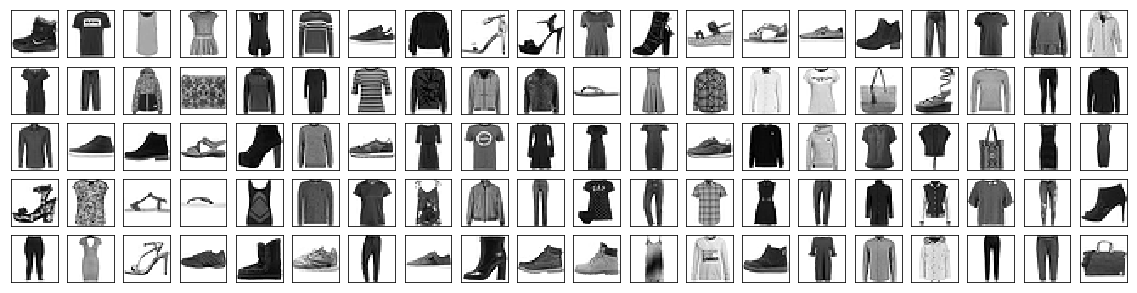

In [41]:
fig = plt.figure(figsize=(20,5))
i = 0
for img in train.train_data:
    i += 1
    ax = fig.add_subplot(5,20,i,xticks=[],yticks=[])
    ax.imshow(img, cmap = plt.cm.binary)
    if i == 100:
        break


## 2. Multi-class Classification Model
### Libraries

In [30]:
#machine learning
import numpy as np
import torch as t
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
import torchvision

#visualization
from PIL import Image
from PIL import ImageOps
import matplotlib.pyplot as plt 

###  Acquire Data

In [64]:
def trans(x):
    '''Data normalization and preprocessing for FashionMNIST''' 
    x = np.array(x, dtype='float32') / 255
    x = (x - 0.5) / 0.5 
    # Transfer to tensor and add a dimension for applicability of dataloader
    x = t.Tensor(x)
    x = x.unsqueeze(0)
    return x

def trans2(x):
    '''Data normalization and preprocessing for TaobaoIMG''' 
    x = np.array(x, dtype='float32') / 255
    x = (x - 0.5) / 0.5
    x = t.Tensor(x)
    x = x.unsqueeze(1)
    return x

train = FashionMNIST( root='./mnist/', train=True, transform=trans, download=True)
test = FashionMNIST(root='./mnist/', train=False, transform=trans, download=True)

# Pack the dataset in batches
train_batch = DataLoader(dataset = train, batch_size = 128, shuffle = True)
test_batch = DataLoader(dataset = test, batch_size = 128, shuffle = False)

### CNN Model

In [3]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv_1 = nn.Sequential(# input: (28,28)
            nn.Conv2d(1,16,5,stride = 1,padding = 2),#(16,28,28), padding = (kernel_size - 1)/2
            nn.BatchNorm2d(16),# Batch Normalization
            nn.ReLU(),# Activation function
            nn.MaxPool2d(kernel_size = 2)# output: (16,14,14)
            )
        self.conv_2 = nn.Sequential(# input:(16,14,14)
            nn.Conv2d(16,32,5,stride = 1,padding = 2),#(32,14,14)
            nn.BatchNorm2d(32),# Batch Normalization
            nn.ReLU(),# Activation function
            nn.MaxPool2d(kernel_size = 2)# output: (37,7,7)
            )
        self.output = nn.Linear(32*7*7, 10)# Linearize
        
    def forward(self, data):
        data = self.conv_1(data)
        data = self.conv_2(data)
        data = data.reshape(data.shape[0],-1)# Flatten
        data = self.output(data)
        return data

### Training

In [82]:
cnn = CNN()
cnn = cnn.cuda(0)# Train with GPU
optimizer = t.optim.Adam(cnn.parameters(), lr=0.0001)# Adam optimizer uses momentum and adagrad proporty which allow the model to train better
loss_function = nn.CrossEntropyLoss()# Choose Cross Entropy to calculate the loss function
epo = 30

for epoch in range(epo):
    for step, (x, y) in enumerate(train_batch):
        b_x = Variable(x).cuda(0)# Train input
        b_y = Variable(y).cuda(0)# Train labels
 
        output = cnn(b_x)# Forward
        loss = loss_function(output, b_y)
        optimizer.zero_grad()# Reset gradient
        loss.backward()# Calculate gradient
        optimizer.step()# Update weights
        predict = t.max(output, 1)[1]# Prediction
        
 
        if step % 100 == 0:
            # Calculate score
            correct_num = (predict == b_y).sum()
            score = 100*float(correct_num)/len(b_x)
            print('Epoch:', epoch, '|Step:', step, '|train loss:%.4f'%loss.data[0], '|Score:%.2f %%'%score)
            

F:\Anaconda\lib\site-packages\ipykernel\__main__.py:25: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 0 |Step: 0 |train loss:2.4105 |Score:10.94 %
Epoch: 0 |Step: 100 |train loss:1.0691 |Score:71.88 %
Epoch: 0 |Step: 200 |train loss:0.7600 |Score:81.25 %
Epoch: 0 |Step: 300 |train loss:0.5951 |Score:83.59 %
Epoch: 0 |Step: 400 |train loss:0.5232 |Score:84.38 %
Epoch: 1 |Step: 0 |train loss:0.5639 |Score:75.00 %
Epoch: 1 |Step: 100 |train loss:0.5027 |Score:84.38 %
Epoch: 1 |Step: 200 |train loss:0.4384 |Score:87.50 %
Epoch: 1 |Step: 300 |train loss:0.5089 |Score:82.03 %
Epoch: 1 |Step: 400 |train loss:0.3354 |Score:89.06 %
Epoch: 2 |Step: 0 |train loss:0.4432 |Score:85.94 %
Epoch: 2 |Step: 100 |train loss:0.3796 |Score:83.59 %
Epoch: 2 |Step: 200 |train loss:0.4251 |Score:87.50 %
Epoch: 2 |Step: 300 |train loss:0.3368 |Score:87.50 %
Epoch: 2 |Step: 400 |train loss:0.3753 |Score:87.50 %
Epoch: 3 |Step: 0 |train loss:0.4582 |Score:83.59 %
Epoch: 3 |Step: 100 |train loss:0.3032 |Score:89.84 %
Epoch: 3 |Step: 200 |train loss:0.3250 |Score:88.28 %
Epoch: 3 |Step: 300 |train loss:0.28

### Test

In [85]:
cnn.eval()
testloss = 0.
testacc = 0.
for (img, label) in test_batch:
    img = Variable(img).cuda(0)
    label = Variable(label).cuda(0)

    output = cnn(img)
    _, predict = t.max(output, 1)
    num_correct = (predict == label).sum()
    testacc += float(num_correct.data[0])

testacc /= len(test.test_data)
print("Test Acc: %.2f %%" %(100*testacc))

F:\Anaconda\lib\site-packages\ipykernel\__main__.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Test Acc: 90.94 %


## 3. Web Crawler

In [74]:
from bs4 import BeautifulSoup
import requests
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
import urllib

browser = webdriver.Chrome()# Open chrome with seleniun
path = 'https://list.tmall.com/search_product.htm?q=T%E6%81%A4&closedKey=inseason'
browser.get(path)# Open the T-shirt search page on Taobao and get all the source code

_* Now browse the generated webpage until the bottom, because the images won't load until they are presented on the screen._

In [ ]:
html = browser.page_source
soup = BeautifulSoup(html)
i = 0

# Find and download the images to local repertory
for link in soup.find_all('a',{'class':'productImg'}):
    i+=1
    print(i, link.get('data-p'))
    urllib.request.urlretrieve( 'https:'+link.find_all('img')[0].get('src'), 'T-shirt/'+link.get('data-p') + ".jpg")

## 4. Classification

### Load Images

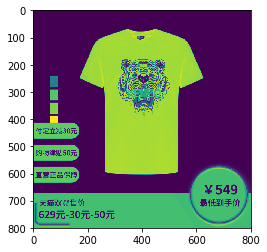

In [99]:
img_arr = []
for i in range(60):
    img_orig = Image.open('T-shirt/'+ str(i+1) +'-10.jpg').convert('L')# Open the downloaded images and convert them to gray scale
    img_orig = ImageOps.invert(img_orig)# Invert black and white
    img_orig = np.array(img_orig, dtype='float32') # Convert to array
    img_arr.append(img_orig)
plt.imshow(img_arr[0])# Show image

### Reduce Resolution

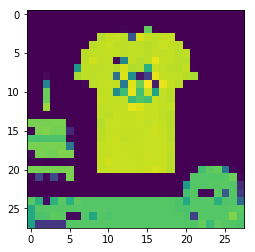

In [100]:
for i in range(len(img_arr)):
    img=Image.fromarray(img_arr[i])
    img = img.resize((28, 28))
    img_arr[i] = np.array(img, dtype='float32')
plt.imshow(img_arr[0])

### Image Enhancement

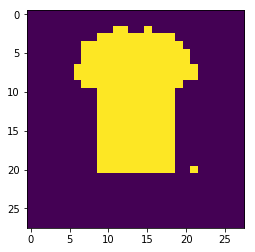

In [101]:
for i in range(len(img_arr)):
    for j in range(28):
        for k in range(28):
            if img_arr[i][j][k]>0:
                img_arr[i][j][k] = 255
    img_arr[i][21:] = 0
    img_arr[i][:,:6] = 0
    img_arr[i][:,22:] = 0
plt.imshow(img_arr[0])

### Data Normalization and Preprocessing

In [102]:
img_arr = trans2(img_arr)

### Classification and Scoring

In [103]:
cnn.eval()
cnn = cnn.cpu()
output = cnn(img_arr)
_, predict = t.max(output, 1)
num_correct = (predict == 0).sum()
t_acc = float(num_correct)/len(img_arr)
print("Application Acc: %.2f %%" %(100*t_acc))

Application Acc: 83.33 %


## My Experiences
1. PyTorch is an easy-to-use open source machine learning library which makes it possible to build and customize our own deep learning model. This allows me to focus on adjusting model parameters rather than debugging the code. The computing process can be done using GPU, which improves the efficiency profoundly. However, there are still much to learn about this powerful tool.
2. Do batch normalization, not only with input data, but with the output of each layer as well. This helps improve convergence speed.
3. Use dataloader to split dataset into batches when the dataset is big. 
4. With a web crawler we can do many useful things, like extracting and analysing commits from a movie forum. I'll dig deep into such application in the future.
5. Before classification, use image processing skills to reduce images' noise.

## Reference
[1] Hanxiao. Fashion-MNIST. https://github.com/zalandoresearch/fashion-mnist <br>
[2] Bushuhui. Machinelearning_Notebook. https://github.com/bushuhui/machinelearning_notebook/tree/master/6_pytorch<br>
[3] Wenboyu. Python爬取淘宝搜索页，使用Selenium+BeautifulSoup. https://blog.csdn.net/wenboyu/article/details/78176859<br>
[4] Thenewboston. Python Programming Tutorial - 25 - How to Build a Web Crawler. https://www.youtube.com/watch?v=XjNm9bazxn8&t=0s&index=26&list=PL6gx4Cwl9DGAcbMi1sH6oAMk4JHw91mC_